# Solution : Prédiction de la meilleure distance obtenue avec le club de golf bois 3

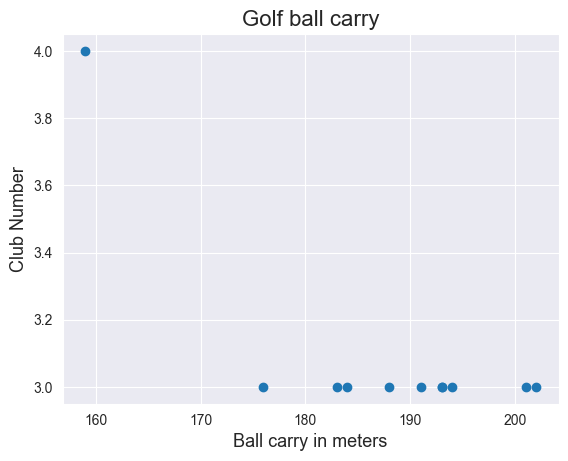

int64      3
float64    3
Name: count, dtype: int64
   Carry distance  Ball speed  Apex  Launch angle  Dispersion  \
0             188         131    26          14.8         5.3   
1             176         126    37          20.7        37.6   
2             193         134    31          16.7        25.7   
3             193         132    26          14.8         7.4   
4             183         127    34          19.3        10.9   
5             201         138    22          12.1         2.4   
6             194         133    30          16.8        18.1   
7             184         132    30          16.6        29.2   
8             191         130    29          17.1        12.6   
9             202         138    27          13.3        17.8   

   Distance to flag  
0               8.4  
1              47.4  
2              30.1  
3               9.2  
4              16.9  
5              18.9  
6              22.1  
7              35.7  
8              15.2  
9           

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_columns = 99

golf = pd.read_csv('golf-data.csv')

stripped_commas_a = golf["Launch angle"].str.replace(",",".")
golf["Launch angle"] = stripped_commas_a.astype('float')

stripped_commas_d = golf["Dispersion"].str.replace(",",".")
golf["Dispersion"] = stripped_commas_d.astype('float')

stripped_commas_dd = golf["Distance to flag"].str.replace(",",".")
golf["Distance to flag"] = stripped_commas_dd.astype('float')

plt.scatter(golf["Carry distance"],golf["Club"])
plt.title("Golf ball carry", fontsize=16)
plt.xlabel("Ball carry in meters", fontsize=13)
plt.ylabel("Club Number", fontsize=13)
#plt.yticks(np.arange(min(y), max(y)+1, 1.0))
plt.show()

#numéro du club de golf
club_golf_number = 3
golf = golf[golf["Club"] == club_golf_number]

#filter_club = golf["Club"] == club_golf_number
#golf.where(filter_club, inplace = True)

#On ne prend pas en compte si la donnée de Portee est absente
golf.dropna(subset=['Carry distance'], inplace = True)

del golf["Club"]
del golf["Total distance"]

print(golf.dtypes.value_counts())
print(golf.head(25))


In [2]:
# Normaliser toutes les colonnes de sorte que les valeurs soient comprises entre 0 et 1 sauf pour la colonne cible.
portee_col = golf['Carry distance']
golf = (golf - golf.min())/(golf.max() - golf.min())
golf['Carry distance'] = portee_col

golf.head(20)

,Carry distance,Ball speed,Apex,Launch angle,Dispersion,Distance to flag
0,188,0.416667,0.266667,0.313953,0.082386,0.000000
1,176,0.000000,1.000000,1.000000,1.000000,1.000000
2,193,0.666667,0.600000,0.534884,0.661932,0.556410
3,193,0.500000,0.266667,0.313953,0.142045,0.020513
4,183,0.083333,0.800000,0.837209,0.241477,0.217949
5,201,1.000000,0.000000,0.000000,0.000000,0.269231
6,194,0.583333,0.533333,0.546512,0.446023,0.351282
7,184,0.500000,0.533333,0.523256,0.761364,0.700000
8,191,0.333333,0.466667,0.581395,0.289773,0.174359
9,202,1.000000,0.333333,0.139535,0.437500,0.412821


## Modèle univarié

Un modèle univarié n'utilise qu'une seule caractéristique d'entrée à la fois pour prédire la distance portée. Cela permet d'identifier rapidement quel indicateur (vitesse de balle, angle, etc.) explique le mieux la performance sans être influencé par les autres variables.

In [3]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def knn_train_test(k, train_col, target_col, df):
    knn = KNeighborsRegressor(n_neighbors=k)
    np.random.seed(0)
    
    # Randomiser l'ordre des lignes du DataFrame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    # Diviser le nombre de lignes de moitié.
    last_train_row = int(len(rand_df) / 2)

    
    # Sélectionner la première moitié en set de training.
    # Sélectionner la seconde moitié en set de test.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    #print(train_df)
    #print("-------------------")
    #print(test_df)

    # Ajuster un modèle KNN utilisant la valeur par défaut k.
    knn.fit(train_df[[train_col]], train_df[target_col])

    # faire des prédictions en utilisant ce modèle.
    predicted_labels = knn.predict(test_df[[train_col]])
    
    # Calculer et retourner la valeur RMSE.
    mse = mean_squared_error(test_df[target_col], predicted_labels)
    rmse = np.sqrt(mse)
    
    return rmse

In [4]:
rmse_results = {}
train_cols = golf.columns.drop('Carry distance')

#train_cols.head()
# Pour chaque colonne (excepté 'Carry distance'), entrainer un modèle et retourner la valeur RMSE.
# et ajouter cette valeur au dictionnaire 'rmse_results'.
k = 3

for col in train_cols:
    rmse_val = knn_train_test(k ,col, 'Carry distance', golf)
    rmse_results[col] = rmse_val

# Créer un objet Series depuis le dictionnaire
# ainsi nous pouvons facilement voir les résultats, les trier, etc…
rmse_results_series = pd.Series(rmse_results)
rmse_results_series.sort_values()



Ball speed          3.895867
Launch angle        5.316641
Dispersion          5.331250
Distance to flag    5.331250
Apex                6.656659
dtype: float64

In [5]:



def knn_train_test2(train_col, target_col, df):
    np.random.seed(0)
    
    # Randomiser l'ordre des lignes du DataFrame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    # Diviser le nombre de lignes de moitié.
    last_train_row = int(len(rand_df) / 2)

    # Sélectionner la première moitié en set de training.
    # Sélectionner la seconde moitié en set de test.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [1,2,3]
    k_rmses = {}
    
    for k in k_values:
        # Ajuster un modèle KNN utilisant la valeur de k en paramètre.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[[train_col]], train_df[target_col])
        
        # faire des prédictions en utilisant ce modèle.
        predicted_labels = knn.predict(test_df[[train_col]])
        
        # Calculer et retourner la valeur RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

In [6]:
feature_k_rmse_results = {}

# Pour chaque colonne (excepté 'Carry distance'), entrainer un modèle et retourner la valeur RMSE.
# et ajouter cette valeur au dictionnaire 'rmse_results'.
train_cols = golf.columns.drop('Carry distance')
for col in train_cols:
    rmse_val = knn_train_test2(col, 'Carry distance', golf)
    feature_k_rmse_results[col] = rmse_val

feature_k_rmse_results

df_rmse = pd.DataFrame.from_dict(feature_k_rmse_results, orient='index')
df_rmse.columns = [f'k={k}' for k in df_rmse.columns]
#df_rmse = df_rmse.sort_values('k=3')  # optional sorting by best column

print(df_rmse.round(3))

                     k=1    k=2    k=3
Ball speed         4.290  4.410  3.896
Apex               8.485  5.878  6.657
Launch angle       8.485  6.177  5.317
Dispersion        10.900  6.921  5.331
Distance to flag   9.818  9.138  5.331


Ball speed
average_rmse: 4.19853476259843
Apex
average_rmse: 7.006621777836114
Launch angle
average_rmse: 6.659496848070659
Dispersion
average_rmse: 7.7172578189634065
Distance to flag
average_rmse: 8.095811067031777


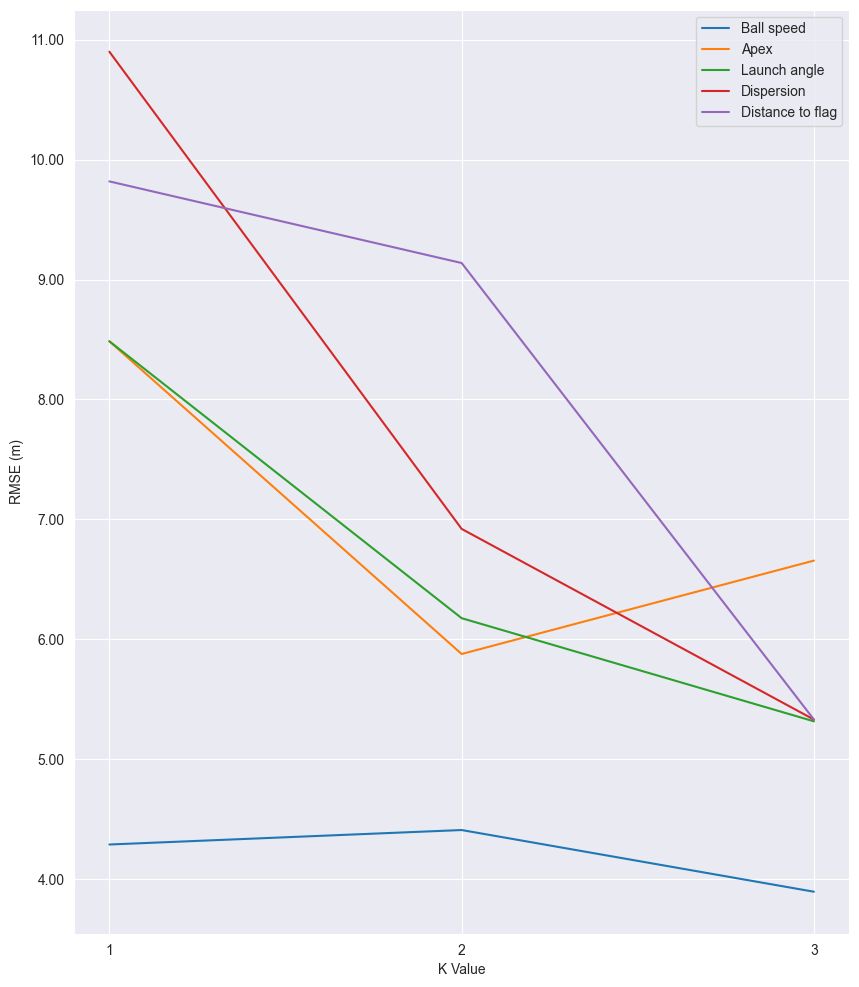

In [7]:
best_features = {}
plt.figure(figsize=(10, 12))

for key, value in feature_k_rmse_results.items():
    x = list(value.keys())
    y = list(value.values())

    order = np.argsort(x)
    x_ordered = np.array(x)[order]
    y_ordered = np.array(y)[order]
    print(key)
    print('average_rmse: '+str(np.mean(y)))
    best_features[key] = np.mean(y)

    plt.plot(x_ordered, y_ordered, label=key)
    plt.xlabel("K Value")
    plt.ylabel("RMSE (m)")

ax = plt.gca()
ax.xaxis.set_major_locator(plticker.MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(plticker.FormatStrFormatter('%.2f'))
plt.legend()
plt.show()

Le graphique ci-dessus montre l'évolution de la RMSE selon le nombre de voisins *k* pour chaque variable. On constate que `Vitesse de balle` reste la courbe la plus basse, surtout à partir de k=3, ce qui confirme que c'est la caractéristique la plus prédictive sur nos 10 coups. Les autres variables nécessitent davantage de voisins pour se stabiliser et offrent une RMSE plus élevée, d'où leur classement derrière la vitesse.

In [8]:
sorted_features_list = sorted(best_features, key=best_features.get)
sorted_features_list

['Ball speed', 'Launch angle', 'Apex', 'Dispersion', 'Distance to flag']

## Modèle multivarié

Le modèle multivarié combine plusieurs caractéristiques simultanément. On observe ainsi les gains potentiels quand la vitesse de balle est couplée à l'angle de lancement, l'apex ou la dispersion, au prix d'une complexité un peu plus élevée.

In [9]:
def knn_train_test3(train_cols, target_col, df):
    np.random.seed(0)
    
    # Randomise l'ordre des lignes du DataFrame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    # Diviser le nombre de lignes de moitié.
    last_train_row = int(len(rand_df) / 2)
    
    # Sélectionner la première moitié pour le set de training.
    # Sélectionner la seconde moitié pour le set de test.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [3]
    k_rmses = {}
    
    for k in k_values:
        # Ajuster le modèle en utilisant la valeur k.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])
        
        # Faire des prédictions en utilisant le modèle.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculer et retourner la valeur RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
        
    return k_rmses



In [10]:
k_rmse_features ={}

sorted_features_list = sorted(best_features, key=best_features.get)

best_two_features = sorted_features_list[0:2]
best_three_features = sorted_features_list[0:3]
best_four_features = sorted_features_list[0:4]

k_rmse_features["best_two_rmse"]  = knn_train_test3(best_two_features, 'Carry distance', golf)
k_rmse_features["best_three_rmse"] = knn_train_test3(best_three_features, 'Carry distance', golf)
k_rmse_features["best_four_rmse"] = knn_train_test3(best_four_features, 'Carry distance', golf)

label_map = {
    "best_two_rmse": " + ".join(best_two_features),
    "best_three_rmse": " + ".join(best_three_features),
    "best_four_rmse": " + ".join(best_four_features)
}

df_multi = (
    pd.DataFrame.from_dict(k_rmse_features, orient='index')
      .rename(columns=lambda k: f'k={k}')
      .rename(index=label_map)
      .round(3)
)

df_multi = df_multi[sorted(df_multi.columns, key=lambda c: int(c.split('=')[1]))]

df_multi


,k=3
Ball speed + Launch angle,5.317
Ball speed + Launch angle + Apex,4.860
Ball speed + Launch angle + Apex + Dispersion,6.657


Ce tableau compare la RMSE obtenue quand on alimente le modèle KNN avec 2, 3 ou 4 variables classées par importance. On voit que la combinaison `Ball speed + Launch angle` descend jusqu'à ~5.32 m à k=3, et qu'ajouter `Apex` améliore encore légèrement la précision (4.86 m). En revanche, intégrer la dispersion en quatrième variable dégrade la performance, signe que l'information est redondante ou bruitée sur ce petit échantillon.

## Variation des hyper paramètres

In [11]:
def knn_train_test4(train_cols, target_col, df):
    np.random.seed(0)
    
    # Randomise l'ordre des lignes du DataFrame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    # Diviser le nombre de lignes de moitié.
    last_train_row = int(len(rand_df) / 2)
    
    # Sélectionner la première moitié pour le set de training.
    # Sélectionner la seconde moitié pour le set de test.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [1, 2, 3]
    k_rmses = {}
    
    for k in k_values:
        # Ajuster le modèle en utilisant la valeur k.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])
        
        # Faire des prédictions en utilisant le modèle.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculer et retourner la valeur RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
        
    return k_rmses

In [12]:
features = [best_two_features, best_three_features]

k_rmse_results = {}
k_rmse_results["best_two_features"] = knn_train_test4(best_two_features, 'Carry distance', golf)
k_rmse_results["best_three_features"] = knn_train_test4(best_three_features, 'Carry distance', golf)

label_map = {
    "best_two_features": " + ".join(best_two_features),
    "best_three_features": " + ".join(best_three_features)
}

df_k_results = (
    pd.DataFrame.from_dict(k_rmse_results, orient='index')
      .rename(columns=lambda k: f'k={k}')
      .rename(index=label_map)
      .round(3)
)

df_k_results = df_k_results[sorted(df_k_results.columns, key=lambda c: int(c.split('=')[1]))]

df_k_results


,k=1,k=2,k=3
Ball speed + Launch angle,4.290,4.41,5.317
Ball speed + Launch angle + Apex,4.382,4.41,4.860


On lit ainsi l'effet du paramètre k sur les deux meilleurs ensembles de variables : avec `Ball speed + Launch angle`, k=1 reste légèrement devant k=2, tandis que l'ajout de `Apex` stabilise les deux valeurs autour de 4.41 m. Cela confirme que réduire le nombre de voisins à 1-2 suffit pour ce petit échantillon, même quand on ajoute une troisième caractéristique.

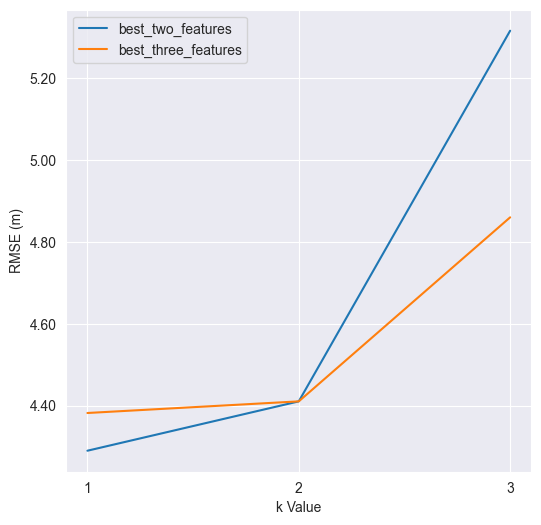

In [13]:
plt.figure(figsize=(6, 6))

for key, value in k_rmse_results.items():
    x = list(value.keys())
    y = list(value.values())
    plt.plot(x, y, label=key)
    plt.xlabel("k Value")
    plt.ylabel("RMSE (m)")

ax = plt.gca()
ax.xaxis.set_major_locator(plticker.MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(plticker.FormatStrFormatter('%.2f'))

plt.legend()
plt.show()


# Quel fer faut-il jouer pour une distance au drapeau donné par son télémètre ou montre GPS

# Distance et fer tapé au practice

In [14]:
import pandas as pd
import numpy as np
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import seaborn as sb
from itertools import cycle
import sys
import warnings
import itertools


In [15]:
def read_csv_data(file,delimiter):

    cols = ["Carry distance mts","Total distance","Club","Ball speed","Apex","Launch angle","Dispersion","Distance to flag"]
    df = pd.read_csv(file,delimiter=delimiter, names=cols)
    
    df = df.drop(df.index[0])
    
    #print(df.head(20))
    #print(df.describe())
    
    return df


In [16]:
def transform_features(df,golf_club_number=3):

    stripped_commas_1 = df["Carry distance mts"].str.replace(",",".")
    df["Carry distance mts"] = stripped_commas_1.astype('float')
    
    stripped_commas_2 = df["Ball speed"].str.replace(",",".")
    df["Ball speed"] = stripped_commas_2.astype('float')
    
    stripped_commas_3 = df["Apex"].str.replace(",",".")
    df["Apex"] = stripped_commas_3.astype('float')
    
    stripped_commas_4 = df["Launch angle"].str.replace(",",".")
    df["Launch angle"] = stripped_commas_4.astype('float')

    stripped_commas_5 = df["Dispersion"].str.replace(",",".")
    df["Dispersion"] = stripped_commas_5.astype('float')

    stripped_commas_6 = df["Distance to flag"].str.replace(",",".")
    df["Distance to flag"] = stripped_commas_6.astype('float')

    stripped_commas_7 = df["Club"].str.replace(",",".")
    df["Club"] = stripped_commas_7.astype('int')
         
    #Club Choice
    df = df[df["Club"] == golf_club_number]

    #caractéristiques non utiles au modèle
    del df["Total distance"]
    del df["Distance to flag"]
    del df["Club"]
   
    #print(df)

    return df

In [17]:
def describe_data(df):
    
    
    cols = ["Carry distance mts","Ball speed","Apex","Launch angle","Dispersion"]
    dict_data = {}
    
    for col in cols:
        mean = df[[col]].mean()
        maxi = df[[col]].max()
        dict_data[col] = {"mean":mean, "max":maxi}

    #df = pd.DataFrame(dict_data)
    #print(df)  
    
    return dict_data

In [18]:
def select_features(df, coeff_corr=0.1):
    
    #print(df.head())
    #print(df.info())
    
    #selection des caractéristiques numériques et on étudie leur correlation avec Portee
    df = df.select_dtypes(include=["int","float"])
    abs_corr_coeffs = df[list(df.columns.values)].corr().abs()
    
    #print(abs_corr_coeffs)
    
    #trace de la heatmap
    sb.heatmap(abs_corr_coeffs)
    
    #classe les valeurs de correlaction de la colonne Portee
    abs_corr_coeffs_sorted = df[list(df.columns.values)].corr()["Carry distance mts"].abs().sort_values()
    
    abs_corr_coeffs_sorted[abs_corr_coeffs_sorted > coeff_corr]
    corr_target = abs_corr_coeffs_sorted[abs_corr_coeffs_sorted.index != 'Carry distance mts']
    kept = corr_target[corr_target >= coeff_corr]
    dropped = corr_target[corr_target < coeff_corr]
    if not kept.empty:
        print("Features kept (>= {} correlation):".format(coeff_corr))
        print(kept)
    if not dropped.empty:
        print("Features dropped (< {} correlation):".format(coeff_corr))
        print(dropped)
    
    #Suppression des colonnes avec coeff de corrélation inférieur de 0.4 avec Portee
    transform_df = df.drop(abs_corr_coeffs_sorted[abs_corr_coeffs_sorted < coeff_corr].index, axis=1)
    transform_df.shape[1]

    #print(transform_df.head())
    
    return transform_df

In [19]:
color_cycle = ['xkcd:deep blue', 'xkcd:dusky purple', 'xkcd:melon','xkcd:moss green']
colors = itertools.cycle(color_cycle)
    
def my_scatter(x,y, **kwargs):
    kwargs['color'] = next(colors)
    plt.scatter(x,y, **kwargs)
    
    
def draw_data(df,golf_club_number=3):
    
    #Distance with club
    str_golf_club_number = str(golf_club_number)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(df.index,df["Carry distance mts"])
    ax.set_title("Golf ball carry distance with club n°"+ str_golf_club_number, fontsize=16)
    ax.set_xlabel("Golf ball shots", fontsize=13)
    ax.set_ylabel("Golf ball carry distance mts", fontsize=13)
    ax.set_facecolor('#FFFFFF')


    #fig.patch.set_facecolor('black')
    #plt.style.use("bmh")
    #plt.rcParams.update({"figure.figsize" : (12, 8),
    #                 "axes.facecolor" : "white",
    #                 "axes.edgecolor":  "black"})
    plt.show()
    
    
    #Dataframe PGA and concat with Dataframe of User data
    pga_columns = ["Carry distance mts PGA","Ball speed km/h PGA","Apex PGA","Launch angle PGA","Dispersion PGA"]
    pga_data = { "Carry distance mts PGA" :[281],
                 "Ball speed km/h PGA":[273],
                 "Apex PGA":[31],                
                 "Launch angle PGA":[10.84],  
                 "Dispersion PGA":[0]
               }
    df_pga = pd.DataFrame(pga_data, columns = pga_columns)    
    df_with_pga = pd.concat([df, df_pga], ignore_index = True)
    
    #Dataframe Mean of data User and data PGA witth around values
    df_with_pga_mean = df_with_pga.mean(axis = 0, skipna = True).apply(np.ceil)
 
    #Dataframe from Mean rebuild for plot
    user_and_pga_mean_data = {
        "User data":[df_with_pga_mean["Carry distance mts"],df_with_pga_mean["Ball speed"],df_with_pga_mean["Apex"],df_with_pga_mean["Launch angle"]],
        "PGA data":[df_with_pga_mean["Carry distance mts PGA"],df_with_pga_mean["Ball speed km/h PGA"],df_with_pga_mean["Apex PGA"],df_with_pga_mean["Launch angle PGA"]]
    }
    df_user_and_pga_mean = pd.DataFrame(user_and_pga_mean_data,index=['Ball carry distance', 'Ball speed (km/h)','Ball apex','Ball Launch angle'])
    #Convert to int for histogram
    df_user_and_pga_mean["User data"] = df_user_and_pga_mean["User data"].astype(int)
    df_user_and_pga_mean["PGA data"] = df_user_and_pga_mean["PGA data"].astype(int)
    

    #Compare each features ball on golf ball carry distance    
    pairgrid = sb.pairplot(df, x_vars=['Ball speed','Apex','Launch angle','Dispersion'], y_vars='Carry distance mts', height=3, aspect=0.9,kind="reg")
    
    #change color for each grid
    pairgrid.map_offdiag(my_scatter)
    
    #Title    
    plt.subplots_adjust(top=0.9)
    pairgrid.fig.suptitle('Carry distance compared to golf ball features')
    
    plt.show()
    
    
    #Second Plot Bar of average data compared to PGA
    fig = plt.figure(figsize=(20,8))
        
    ax = df_user_and_pga_mean.plot(kind='bar',color=['#017dc3', '#063c6e'])
    
    #display number on bar
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    
    plt.title("Compare your data with PGA players on golf ball", fontsize=16)
    plt.xlabel("", fontsize=13)
    plt.ylabel("Average", fontsize=13)
    
    
    plt.legend()        
    
    plt.show()
    

In [20]:
def train_and_test(df, k=0):
    
    numeric_train = df.select_dtypes(include=["integer","float"])
    numeric_test  = df.select_dtypes(include=["integer","float"])
    
    lr = linear_model.LinearRegression()
    
    split_train_test_value = np.around((len(df) / 2)).astype('int32')
    #split_train_test_value = 2
    #print(split_train_test_value)
    
    if k == 0:
        
        train = df.iloc[0:split_train_test_value] 
        test  = df.iloc[split_train_test_value:]
        
        #add column to categorize train and test
        train.insert(0, "Type of data", "Training", True)
        test.insert(0, "Type of data", "Testing", True)
        
        #train_cat = train.set_index('Train')
        #test_cat = test.set_index('Test')
        
        train_test_df = pd.concat([train, test]) 
        #train_test_df.index.names=["DataType"]
        #print(train_test_df)
        
        #Draw plot of train data vs test data  
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="When grouping with a length-1 list-like",
                category=FutureWarning
            )
            plot_features = [col for col in ['Ball speed','Apex','Launch angle','Dispersion'] if col in train_test_df.columns]
            if plot_features:
                pairgrid = sb.pairplot(train_test_df, x_vars=plot_features, y_vars='Carry distance mts', height=3, aspect=0.6, hue="Type of data")
                pairgrid.map(sb.kdeplot)
                plt.subplots_adjust(top=0.9)
                pairgrid.fig.suptitle('Comparison of train and test data on golf ball carry distance regarding Ball features')
                plt.show()
        
    
        features = numeric_train.columns.drop("Carry distance mts")
    
        #Entrainement
        res = lr.fit(train[features],train["Carry distance mts"])

        #Impression de la pente entre chaque feature et la feature Portee
        #2.04% de Portee en plus pour 1km/h de vitesse de balle en plus
        improve_pourcent_array = lr.coef_        
        for idx, col_name in enumerate(train[features].columns):
            print("A unit increase in {} is associated with {} unit in increase Ball distance".format(col_name, lr.coef_[idx]))
        
        #print(lr.intercept_)

        
        coeff = pd.DataFrame([improve_pourcent_array], columns=features)
        #print(lr.coef_)
        #print(coeff.head())
        
        #Prediction sur la série des données de test
        predicted_model = lr.predict(test[features])
        
        #Add predicted values to test dataframe
        test.insert(2, "Predicted Carry distance mts", predicted_model) 
        
        df_check = pd.DataFrame({'Carry distance on testing data':test['Carry distance mts'],'Carry distance predicted':test['Predicted Carry distance mts']})
        #print(df_check)

        #Draw plot of test data on predict data         
        df_check.reset_index(drop='True').plot()
        x_scale_limit = df_check.index.max() / 2
        plt.xlim(1, np.abs(x_scale_limit))
        plt.title("Comparison of Golf ball carry on testing data and Golf ball carry on predicted data", fontsize=16)
        plt.ylabel("Ball carry mts", fontsize=13)
        plt.xlabel("Club shots", fontsize=13)
        plt.show()
        
              
        #Draw plot of test data on predict data              
        plot_features_test = [col for col in ['Ball speed','Apex','Launch angle','Dispersion'] if col in test.columns]
        if plot_features_test:
            pairgrid = sb.pairplot(test, x_vars=plot_features_test, y_vars='Predicted Carry distance mts', height=3, aspect=0.6)
            #pairgrid.map(sb.kdeplot)
            plt.subplots_adjust(top=0.9)
            pairgrid.fig.suptitle('Comparison of predicted ball carry distance regarding testing data ball features')
            plt.show()

               
        #Calcul de l'erreur quadratique moyenne
        test_mse = mean_squared_error(test["Predicted Carry distance mts"], test["Carry distance mts"])    
        test_rmse = np.sqrt(test_mse) 
        
        #coefficient of determination
        score_model = lr.score(test[features],test["Carry distance mts"])
        
        #variance of model
        #standard_deviation_model = np.std(score_model)
        
        #in our model, 82.85% of the variability in Y can be explained using X
        print("score_model R-squared coeff of determination:", score_model)  
        #print("standard deviation model:", standard_deviation_model)
        print("Error of test data on prediction of ball carry distance mts:",test_rmse)
        #So we are an average of 5.86 meters of "carry distance of ball" away 
        #from the ground truth "carry distance" when making predictions on our test set.
        print("Mean of Carry distance mts:", df["Carry distance mts"].mean())
        #doofinder
    
    return lr

Le graphique *Comparison of predicted ball carry distance regarding testing data ball features* trace, feature par feature, les valeurs de test face aux distances prédites. Si la modélisation est cohérente, on observe des nuages alignés: la vitesse élevée entraîne des prédictions de portée plus longues, alors que les coups avec apex très haut ou forte dispersion restent limités. Ce diagnostic visuel permet de repérer d’éventuelles dérives (par exemple une prédiction qui ne varie plus avec l’angle de lancement) et de vérifier que la relation attendue est bien captée sur l’échantillon de test.

Le graphique *Comparison of train and test data on golf ball carry distance* juxtapose les nuages de points des coups utilisés pour l'entraînement et ceux réservés au test, colorés différemment. L'idée est de vérifier visuellement que les deux ensembles ont une distribution similaire sur les variables clés (vitesse, apex, angle, dispersion). Quand les deux nuages se chevauchent comme ici, cela signifie que le modèle évaluera des situations comparables à celles qu'il a apprises, évitant un biais de validation trop optimiste ou au contraire un test déconnecté de la réalité de l'entraînement.

In [21]:
def predict_distance(model, df):
        
    carry_distance_predicted = model.predict(df)    
    #print(carry_distance_predicted)        
    
    df["Predicted Carry distance mts"] = carry_distance_predicted
    
    print(df)

    #Draw plot of test data on predict data              
    plot_vars = [col for col in ['Ball speed','Apex','Launch angle','Dispersion'] if col in df.columns]
    if plot_vars:
        pairgrid = sb.pairplot(df, y_vars='Predicted Carry distance mts', x_vars=plot_vars, height=3, aspect=0.6)
        pairgrid.map(plt.hist, color='darkred')
        plt.subplots_adjust(top=0.9)
        pairgrid.fig.suptitle('Comparison of predicted ball carry distance regarding your data ball features')
        plt.show()    
    
    
    return carry_distance_predicted


Features kept (>= 0.5 correlation):
Launch angle    0.567520
Ball speed      0.734172
Name: Carry distance mts, dtype: float64
Features dropped (< 0.5 correlation):
Dispersion    0.034940
Apex          0.210084
Name: Carry distance mts, dtype: float64


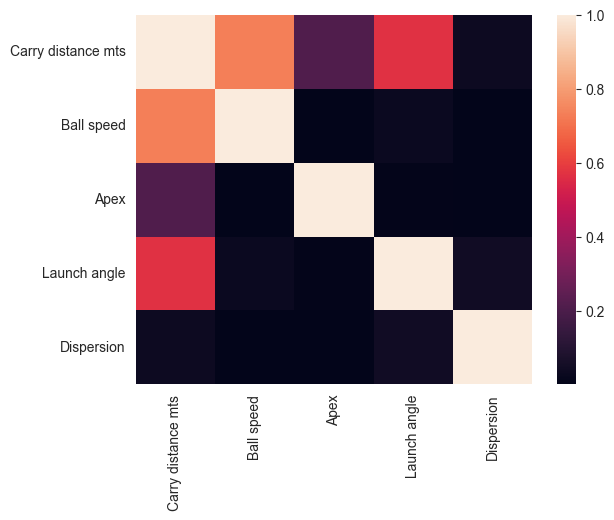

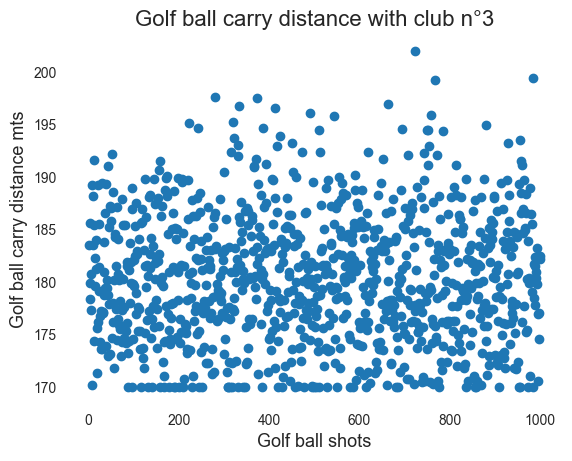

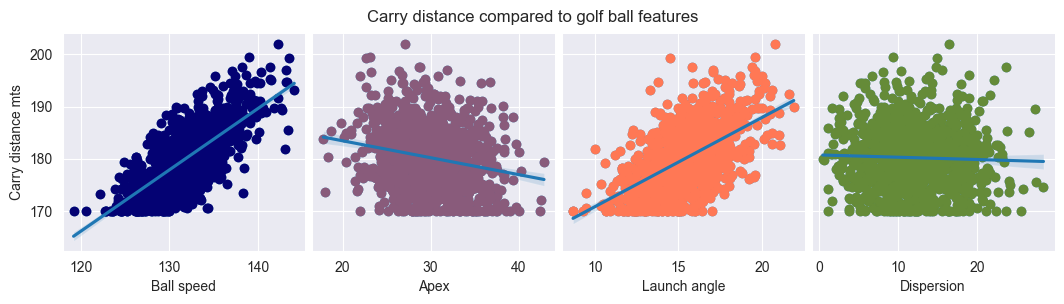

<Figure size 2000x800 with 0 Axes>

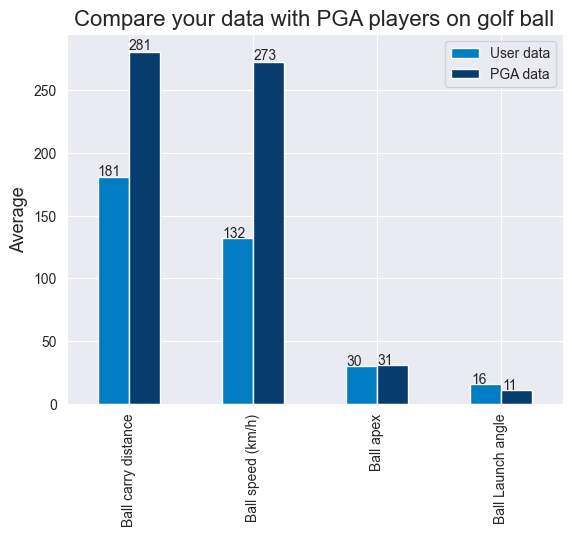

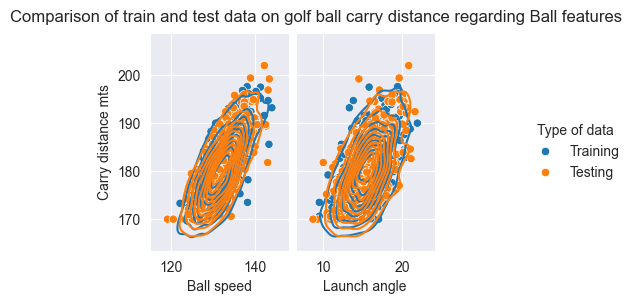

A unit increase in Ball speed is associated with 1.1300342073140004 unit in increase Ball distance
A unit increase in Launch angle is associated with 1.6300377094187037 unit in increase Ball distance


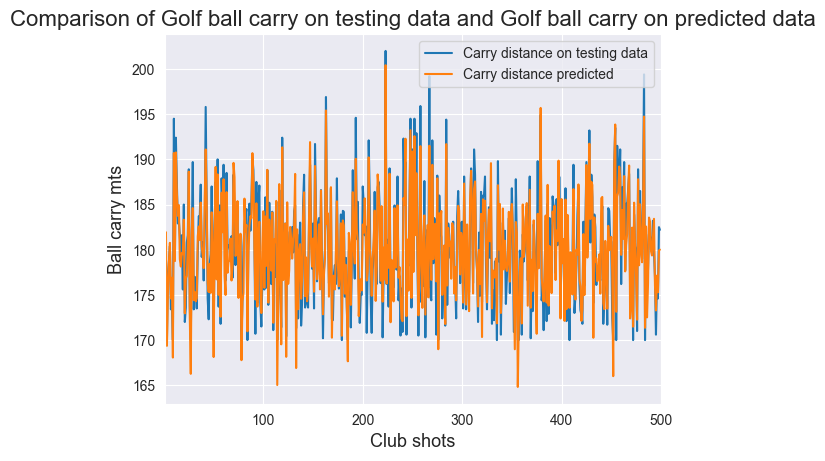

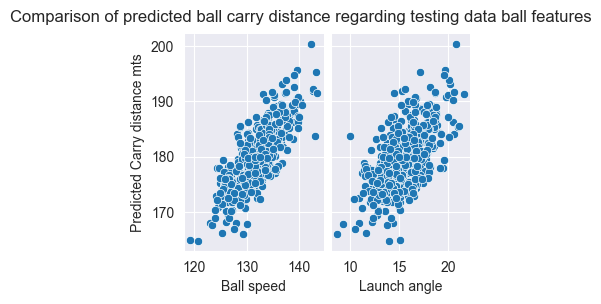

score_model R-squared coeff of determination: 0.8484378581446403
Error of test data on prediction of ball carry distance mts: 2.400236811870538
Mean of Carry distance mts: 180.2395
   Ball speed  Launch angle  Predicted Carry distance mts
0         131          14.8                    177.871604


/Users/arnaudbreton/Digital_projects/machine-learning-linearreg-kneighbours-kfold/.venv/lib/python3.13/site-packages/seaborn/axisgrid.py:1639: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_k = hue_grouped.get_group(label_k)
/Users/arnaudbreton/Digital_projects/machine-learning-linearreg-kneighbours-kfold/.venv/lib/python3.13/site-packages/seaborn/axisgrid.py:1639: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_k = hue_grouped.get_group(label_k)


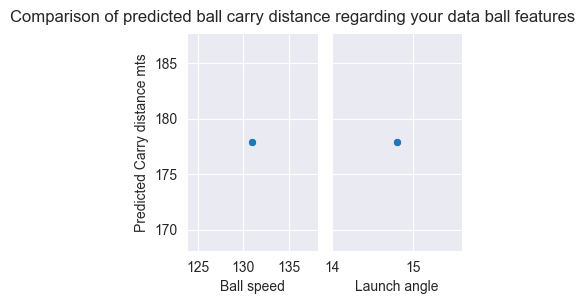

Ball distance carry predicted is: [177.8716036]  meters
Linear regression predictions on 5 test scenarios:
         Scenario  Ball speed  Launch angle  Predicted Carry distance mts
0      Stock shot         132            16                           180
1      Low bullet         134            12                           178
2       High soft         128            18                           181
3        Toe miss         125            14                           170
4  Perfect strike         136            16                           186


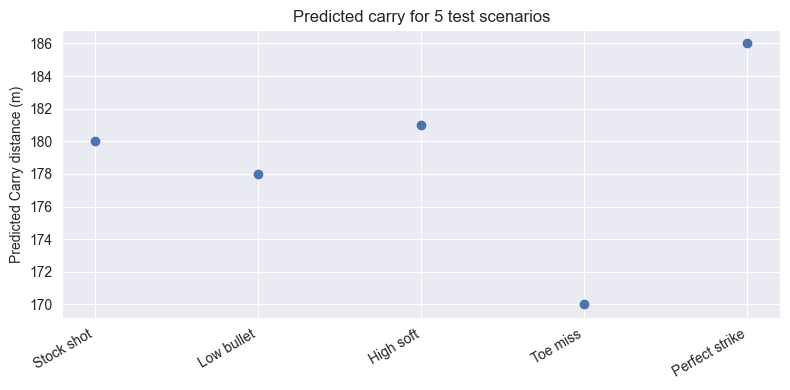

In [22]:
df = read_csv_data('golf-data-extended.csv',',')

golf_club_number = 3

transform_df = transform_features(df, golf_club_number)
#describe_data(transform_df)

coeff_corr = 0.5
filtered_df = select_features(transform_df, coeff_corr)
draw_data(transform_df,golf_club_number)

lr = train_and_test(filtered_df, k=0)

feature_cols = filtered_df.columns.drop("Carry distance mts")

df_to_predict = pd.DataFrame([{"Ball speed":131, "Apex":26, "Launch angle":14.8, "Dispersion":5.3}])
df_to_predict = df_to_predict.reindex(columns=feature_cols, fill_value=0)
predicted_carry_distance = predict_distance(lr,df_to_predict)
print("Ball distance carry predicted is:",predicted_carry_distance," meters")

validation_samples = [
    {"Scenario": "Stock shot", "Ball speed": 132, "Apex": 30, "Launch angle": 15.5, "Dispersion": 6.0},
    {"Scenario": "Low bullet", "Ball speed": 134, "Apex": 22, "Launch angle": 12.5, "Dispersion": 4.0},
    {"Scenario": "High soft", "Ball speed": 128, "Apex": 36, "Launch angle": 18.5, "Dispersion": 8.5},
    {"Scenario": "Toe miss", "Ball speed": 125, "Apex": 28, "Launch angle": 14.0, "Dispersion": 18.0},
    {"Scenario": "Perfect strike", "Ball speed": 136, "Apex": 27, "Launch angle": 16.5, "Dispersion": 5.0}
]
validation_df = pd.DataFrame(validation_samples)
validation_features = validation_df.reindex(columns=feature_cols, fill_value=0)
validation_df["Predicted Carry distance mts"] = lr.predict(validation_features)
validation_df = pd.concat([validation_df[["Scenario"]], validation_features, validation_df[["Predicted Carry distance mts"]]], axis=1)
validation_df['Launch angle'] = validation_df['Launch angle'].round().astype(int)
validation_df['Predicted Carry distance mts'] = validation_df['Predicted Carry distance mts'].round().astype(int)
print("Linear regression predictions on 5 test scenarios:")
print(validation_df)

plt.figure(figsize=(8,4))
plt.plot(validation_df['Scenario'], validation_df['Predicted Carry distance mts'], marker='o', linestyle='none', color='#4C72B0')
plt.ylabel('Predicted Carry distance (m)')
plt.title('Predicted carry for 5 test scenarios')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


Les visualisations ci-dessus résument ce que raconte la séance de practice : le nuage de points permet de voir la dispersion des balles au fil des coups avec le bois 3, la matrice de graphiques met en évidence comment la vitesse, l'apex, l'angle de lancement et la dispersion influencent la portée, tandis que l'histogramme compare directement la moyenne de ces mêmes indicateurs à la référence PGA. On visualise ainsi instantanément où se situent les écarts prioritaires à combler.

Le graphique intitulé *Carry distance compared to golf ball features* est un pairplot régressif : chaque sous-graphique représente la relation entre la portée et l'une des caractéristiques (vitesse, apex, angle ou dispersion), accompagnée de la droite de tendance. Cela permet d'observer immédiatement que la vitesse de balle et l'angle de lancement ont une pente positive marquée (plus de vitesse ou de loft => plus de portée), tandis que l'apex et la dispersion affichent des pentes plates voire négatives, signe qu'ils n'apportent pas de distance supplémentaire et peuvent même en retirer lorsque la balle monte trop haut ou s'éparpille. On peut donc conclure que travailler sur la vitesse et l'optimisation de l'angle de lancement est prioritaire, alors que limiter l'apex et maîtriser la dispersion sert surtout à stabiliser la trajectoire.